# Coinrun VAE Visualization

## Part I

**imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import yaml

**load and visualize training data**

In [2]:
# load data
obs = np.load('./dataset/data.npz')['obs']
obs = obs.astype(np.float32) / 255.0
print(obs.shape)

# aggregate data
dataset = obs.reshape(-1, *obs.shape[2:])
print(dataset.shape)
print(np.min(dataset), np.max(dataset))

(400, 32, 64, 64, 3)
(12800, 64, 64, 3)
0.0 1.0


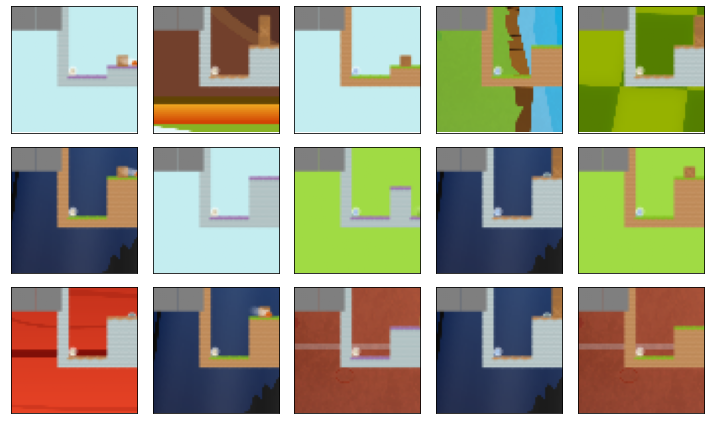

In [3]:
# visualize data
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})

for ax in axs.flat:
    step = random.randint(0, obs.shape[0] - 1)
    env = random.randint(0, obs.shape[1] - 1)
    ax.imshow(obs[step][env])
plt.tight_layout()
plt.show()

**load trained VAE**

In [5]:
from models import *
from experiment import VAEXperiment

with open('configs/vae.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = vae_models[config['model_params']['name']](**config['model_params'])
params = config['exp_params']
exp = VAEXperiment.load_from_checkpoint('logs/VAE_simple_2/lightning_logs/version_1/checkpoints/epoch=2.ckpt',
                                        vae_model=model, params=params,
                                        map_location=torch.device('cpu'))
vae = exp.model
transforms = exp.data_transforms()

**visualize reconstructions and encodings**

(from left to right: original image, reconstructed image, z-image)

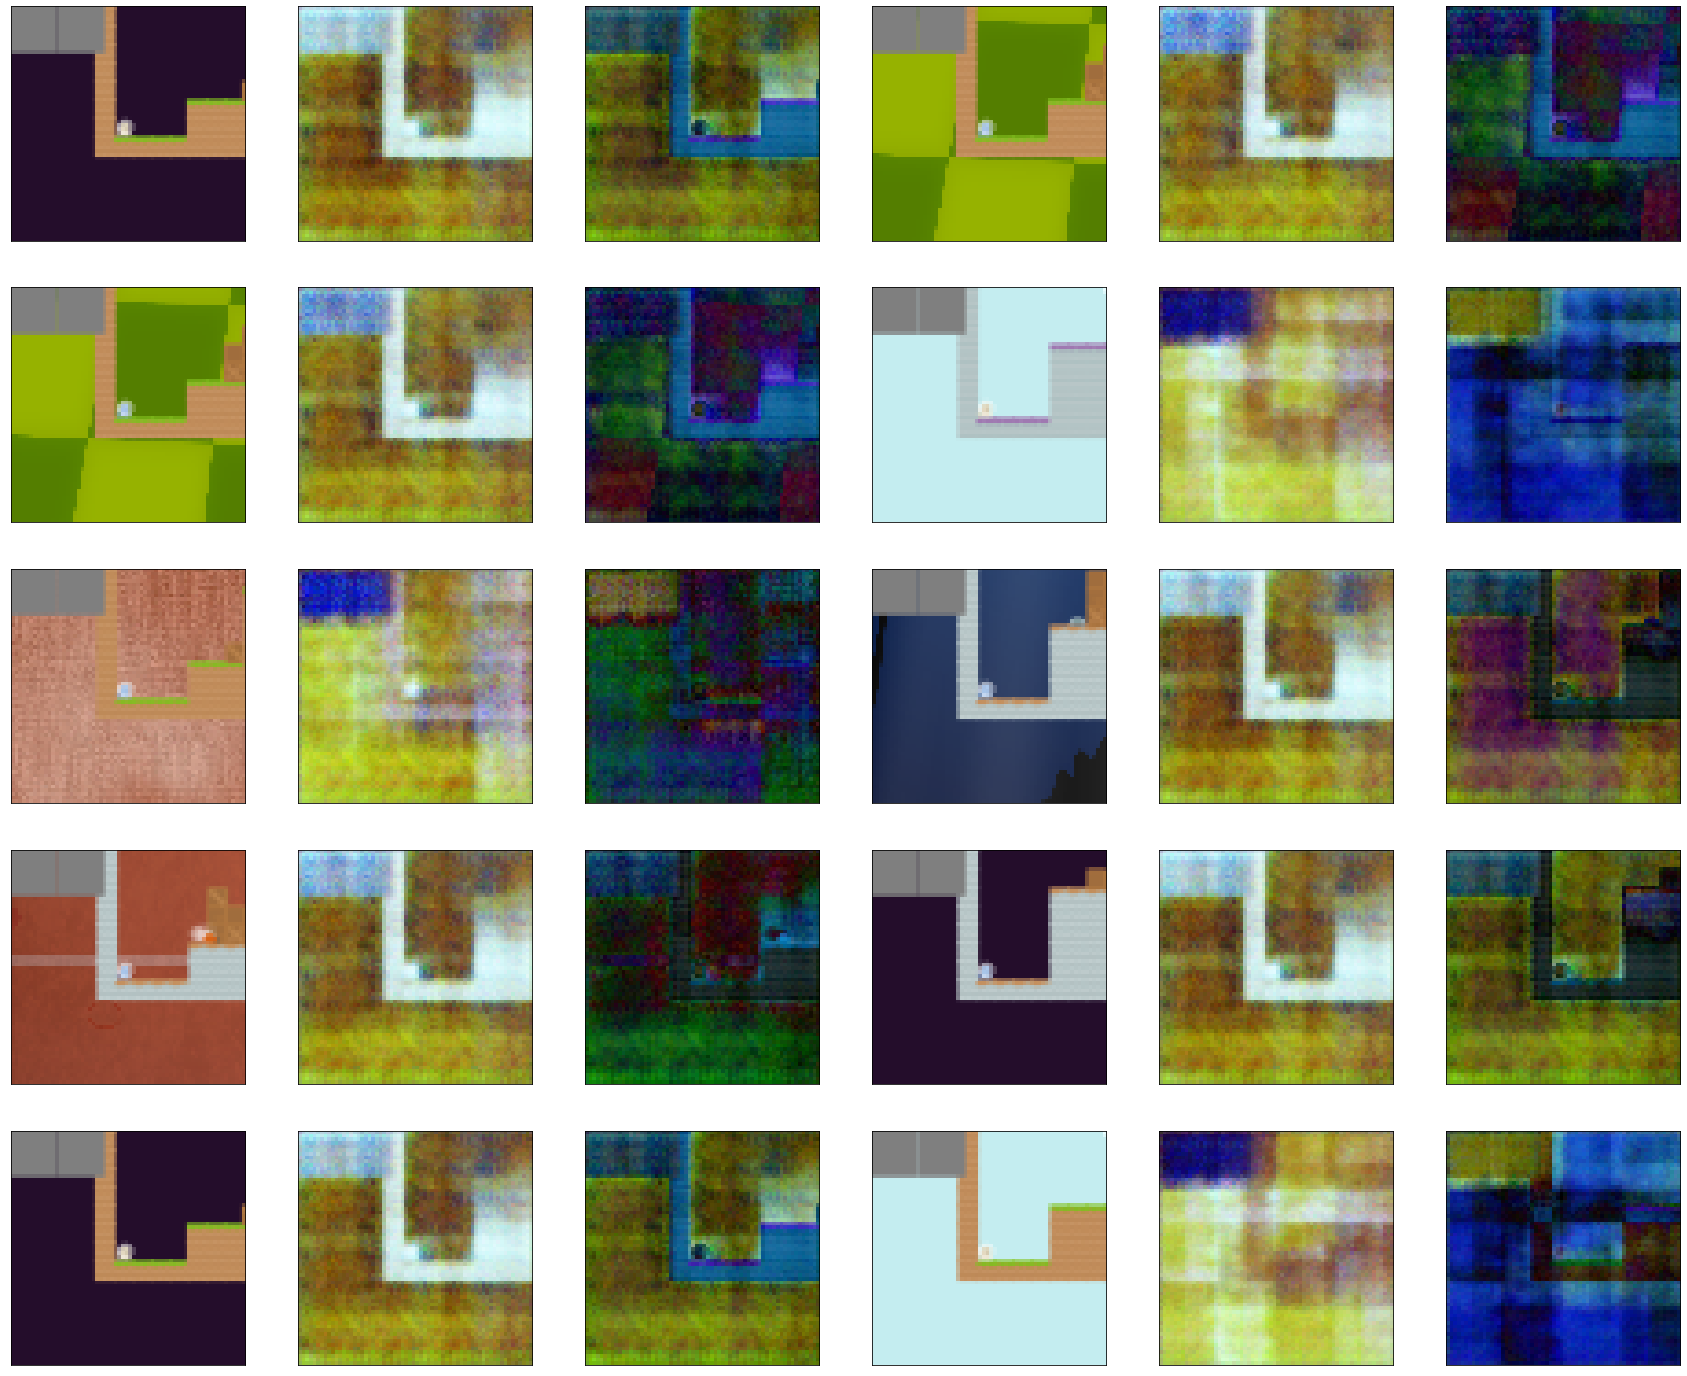

In [6]:
N_ROWS = 5
assert N_ROWS > 1

_, axs = plt.subplots(nrows=N_ROWS, ncols=6, figsize=(30, 5 * N_ROWS), subplot_kw={'xticks': [], 'yticks': []})

# encode/decode
for i in range(2 * N_ROWS):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx]
    
    img_tensor = transforms(dataset[idx]).unsqueeze(0)
    img_r_tensor = vae.generate(img_tensor)
    
    img_r = np.transpose(img_r_tensor.detach().numpy()[0], (1, 2, 0))
    img_r_min, img_r_max = np.min(img_r), np.max(img_r)
    if img_r_min < 0 or img_r_max > 1:
        img_r = (img_r - img_r_min) / (img_r_max - img_r_min)
        
    img_delta = np.abs(img_r - img)
    
    axs[i//2][3*(i%2)+0].imshow(img)
    axs[i//2][3*(i%2)+1].imshow(img_r)
    axs[i//2][3*(i%2)+2].imshow(img_delta)

**some stats**

In [62]:
diffs_avg = []
diffs_std = []
all_z = []

for i in range(100):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx][np.newaxis, ...]
    img_z = vae.encode(img)
    img_r = vae.decode(img_z)

    diffs_avg.append(255 * np.mean(img - img_r))
    diffs_std.append(255 * np.std(img - img_r))
    
    all_z.append(img_z[0])
    
print(f'reconstruction error: avg={np.mean(diffs_avg)}, std={np.mean(diffs_std)}')
print('(for values ranging between 0 and 255)\n')

all_z = np.array(all_z)
print('z-domain means:')
print(np.round(np.mean(all_z, axis=0), decimals=2))
print('\nz-domain stds:')
print(np.round(np.std(all_z, axis=0), decimals=2))
print('\nz-domain mins:')
print(np.round(np.min(all_z, axis=0), decimals=2))
print('\nz-domain maxs:')
print(np.round(np.max(all_z, axis=0), decimals=2))

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Part 2

**visualize z-domain perturbation on 1 dimension**

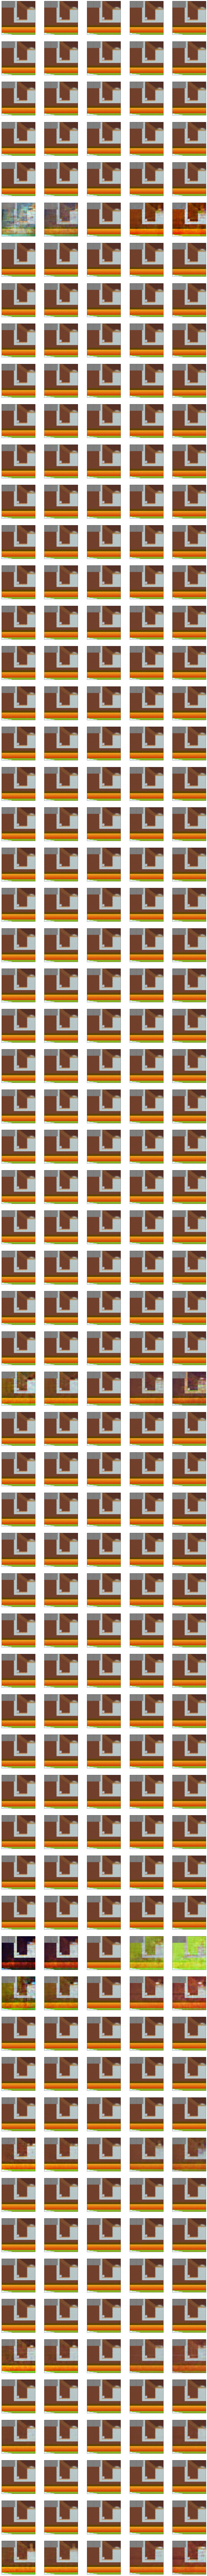

In [14]:
_, axs = plt.subplots(nrows=64, ncols=5, figsize=(25, 5 * 64), subplot_kw={'xticks': [], 'yticks': []})

idx = random.randint(0, len(dataset) - 1)
img = dataset[idx][np.newaxis, ...]
img_z = vae.encode(img)

# encode/decode
for dim in range(64):
    for j, delta in enumerate([-2, -1, 0, 1.0, 2.0]):
        img_z2 = np.copy(img_z)
        img_z2[0][dim] += delta
        img_r = vae.decode(img_z2)

        axs[dim][j].imshow(img_r[0])

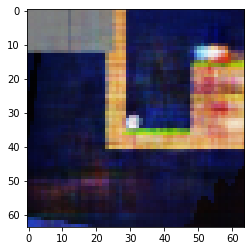

In [43]:
idx = 11
img = dataset[idx][np.newaxis, ...]
img_z = vae.encode(img)
img_z[0,:] += np.random.rand(64) * 4 - 2
img_r = vae.decode(img_z)
plt.imshow(img_r[0])

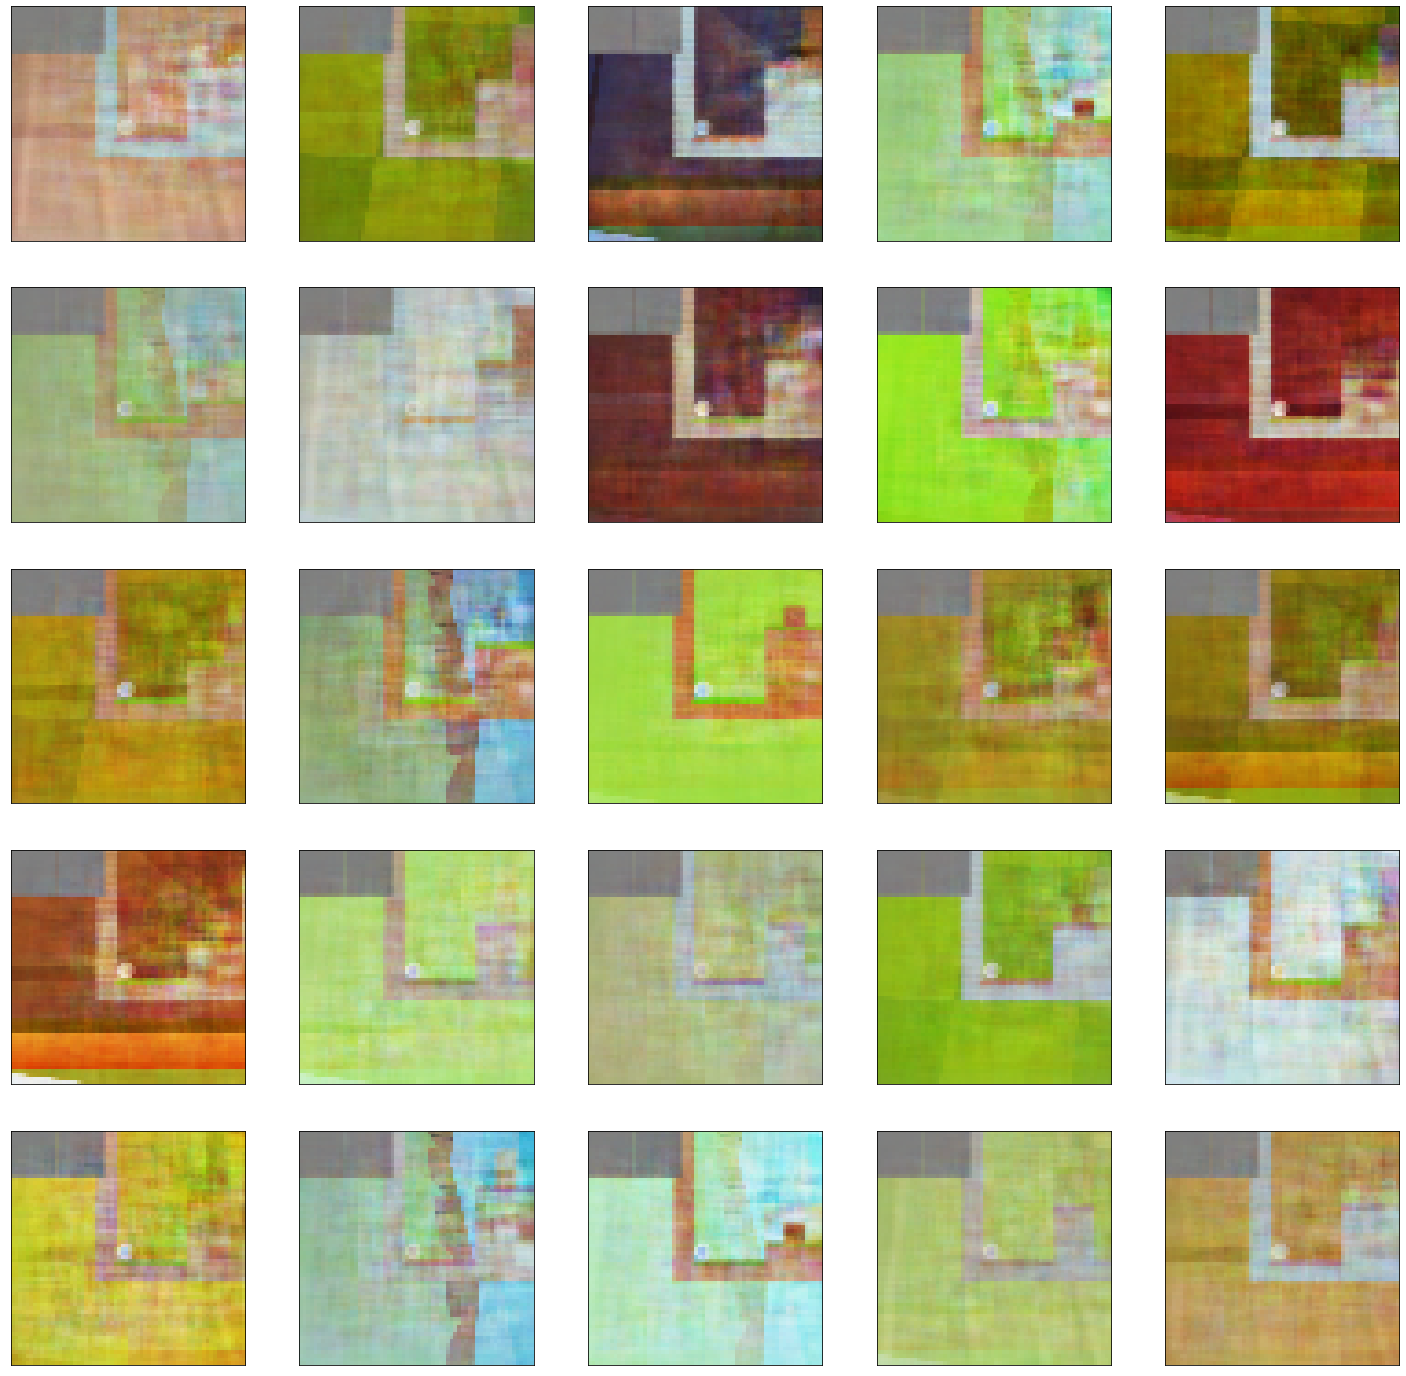

In [76]:
_, axs = plt.subplots(nrows=5, ncols=5, figsize=(25, 25), subplot_kw={'xticks': [], 'yticks': []})

for row in range(5):
    for col in range(5):
        random_z = np.random.rand(1, 64) * 3 - 1.5
        img_r = vae.decode(random_z)
        axs[row][col].imshow(img_r[0])

todo analyze the structure of the z domain
ie values relative to each other for each encoding
so that we have better option than generating them randomly